In [1]:
import mlc_func as mlcf
import numpy as np
import pandas as pd
import keras
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [33]:
mlcf.elf.utils.change_alignment(path='../data/PBE/sz_200/basis_old_nn.json_processed/dimers_processed.hdf5',
                                traj_path='../data/PBE/sz_200/dimers.traj',
                                new_method='water', 
                                save_as ='../data/PBE/sz_200/basis_old_water.json_processed/dimers_processed.hdf5')

{'r_o_o': 1.0, 'r_i_o': 0.05, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'nn'}


In [34]:
def create_target_file(baseline, reference, output, offset = 0):
    targets = np.genfromtxt(reference, delimiter = ',') -\
        np.genfromtxt(baseline, delimiter = ',') - offset
#     species = np.array(['o','h','h']*int(len(targets)/3)).reshape(-1,1)
#     targets = np.concatenate([targets,species], axis = 1)
    pd.DataFrame(targets).to_csv(output, index = None, header = None)

In [72]:
basepath_feat = '../data/PBE/sz_200/basis_old_nn.json_processed/'
basepath_tar = '../data/PBE/sz_200/'
revpath_tar = '../data/BH/dz_custom/'

# basepath_feat = '../data/PBE/sz/basis_old_water.json_processed/'
# basepath_tar = '../data/PBE/sz'
# revpath_tar = '../data/BH/dz_custom_padded/'

systems = ['monomers','dimers','trimers']
# systems = ['16p16']
mono_offset = 0
n_mol = [3,2,1]
# filters = [([True,True] + [False]*10)*3000]

for s,nm in zip(systems, n_mol):
    create_target_file(basepath_tar +'/{}.forces'.format(s),
                      revpath_tar + '/{}.forces'.format(s),
                      basepath_tar +'/{}_targets.forces'.format(s), mono_offset*nm)
        
feature_src = [basepath_feat + s +'_processed.hdf5' for s in systems]
# feature_src = [basepath_feat + s +'.M' for s in systems]
target_src = [basepath_tar +'/' + s +'_targets.forces' for s in systems]
traj_src = [basepath_tar +'/' + s +'.traj' for s in systems]
# filters = np.genfromtxt('../data/BH/dz_custom_padded/filter.idx', dtype =bool)
# filters = np.array([filters, filters]).T.flatten()
nn = mlcf.ml.build_force_mlcf(feature_src, target_src,
                                 traj_src, filters =[], automask_std = 1e-3,
                                  autofilt_percent = 0.005, species = 'h')


{'r_o_o': 1.0, 'r_i_o': 0.05, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'nn'}
(1564, 8)
{'r_o_o': 1.0, 'r_i_o': 0.05, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'nn'}
(8000, 8)
{'r_o_o': 1.0, 'r_i_o': 0.05, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'nn'}
(9000, 8)


In [65]:
old_scaler = nn.scaler

In [14]:
nn.load_all('../../elf_models/mlcf_master/16p16/pbesz_pbedz/')

In [15]:
nn.X_test = nn.scaler.transform(old_scaler.inverse_transform(nn.X_test))
nn.X_train = nn.scaler.transform(old_scaler.inverse_transform(nn.X_train))
nn.X_valid = nn.scaler.transform(old_scaler.inverse_transform(nn.X_valid))

ValueError: operands could not be broadcast together with shapes (3606,6) (8,) (3606,6) 

In [8]:
# nn.model = keras.models.load_model('../../elf_models/mlcf_master/16p16/pbesz_mbp_long/force_o')

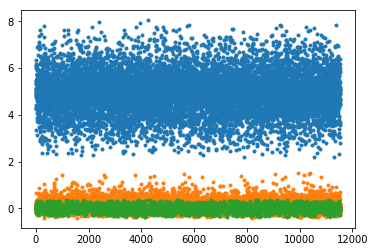

In [73]:
plot(nn.y_train,ls = '', marker = '.')


In [74]:
# learning_curve = nn.learning_curve(steps=8)

In [75]:
nn.nodes_per_layer = 8

In [76]:
nn.train(early_stopping=True, b=1e-8,batch_size=500, restart = False)

--------Epoch = 0----------
Training loss || Validation loss
     3.050154 ||      3.040318
--------Epoch = 500----------
Training loss || Validation loss
     0.130572 ||      0.135935
--------Epoch = 1000----------
Training loss || Validation loss
     0.091214 ||      0.097918
--------Epoch = 1500----------
Training loss || Validation loss
     0.085694 ||      0.091982
--------Epoch = 2000----------
Training loss || Validation loss
     0.083308 ||      0.090285
--------Epoch = 2500----------
Training loss || Validation loss
     0.082123 ||      0.089721


======== Evaluation on test set =============
              RMSE =  0.0796
              MAE = 0.0470
              Max. abs. error = 0.9398


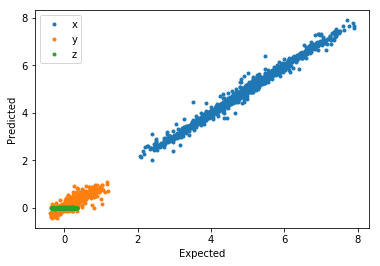

{'rmse': 0.07960472283075012,
 'mae': 0.04703264598860509,
 'max': 0.9398089005050765}

In [77]:
nn.evaluate(plot=True, on='test')

======== Evaluation on test set =============
              RMSE =  0.1172
              MAE = 0.0735
              Max. abs. error = 1.3627


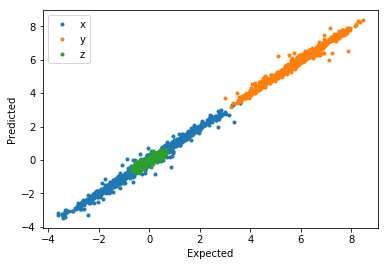

{'rmse': 0.11719203942452741,
 'mae': 0.07353963047777423,
 'max': 1.3626885564791733}

In [62]:
nn.evaluate(plot=True, on='test')

In [78]:
nn.save_all('../../elf_models/mlcf_master/pbe_sz_200/bh_dz_nn/', override=False)

In [54]:
ensemble = mlcf.ml.Ensemble_Network(nn)

In [57]:
ensemble.train_next()

Training model: 2
--------Epoch = 0----------
Training loss || Validation loss
     0.690111 ||      0.689123
--------Epoch = 500----------
Training loss || Validation loss
     0.050323 ||      0.049841
--------Epoch = 1000----------
Training loss || Validation loss
     0.048252 ||      0.048288
--------Epoch = 1500----------
Training loss || Validation loss
     0.047829 ||      0.048089
--------Epoch = 2000----------
Training loss || Validation loss
     0.047680 ||      0.048073


KeyboardInterrupt: 

In [67]:
np.std(ensemble.std_predict(nn.X_test, processed=True), axis = 0)

array([0.00567823, 0.00177418, 0.00192366], dtype=float32)